In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

In [260]:
def generate_data(N, n_cust, prob_new=0, customer_ids=None, income=None):

    if customer_ids is None:
        customer_ids = np.arange(0,n_cust)
    if income is None:
        income = np.random.normal(0,3, len(customer_ids))

    transactions = []

    for t in range(N):
        transaction = {}
        cust = np.random.choice(customer_ids)
        x = np.random.normal()
        spend = 0.5 * income[cust] + x * 0.3 + np.random.normal(0,1)
        transaction['cust_id'] = cust
        transaction['spend'] = spend
        transaction['x'] = x
        transactions.append(transaction)

        # generate a new customer with some probability
        if np.random.random() < prob_new:
            income = np.append(income, np.random.normal(3))
            customer_ids = np.append(customer_ids, max(customer_ids)+1)

    return pd.DataFrame(transactions), income, customer_ids

In [261]:
df, income, customer_ids = generate_data(100, 10)

In [252]:
oc = OneHotEncoder()
ex = pd.DataFrame(oc.fit_transform(df[['cust_id']]).toarray())
ex["cust_id"] = df["cust_id"]

oc.transform(np.array([[10]])).toarray()

In [ ]:
# coords = {"cust_id": df.cust_id.unique()}
# def create_model(spend, x, cust_id, beta_prior=0, alpha_prior=0, cust_exp_prior=None):
with pm.Model() as model:

    n_cust = len(df.cust_id.unique())

    obs = pm.MutableData('obs', df.spend.values)
    x = pm.MutableData('x', df.x.values)
    cust_id = pm.MutableData("cust_id", df.cust_id.values)

    sig = pm.HalfNormal("sig", sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    # if not cust_exp_prior:
        # cust_exp_prior = [0] * n_cust


    cust_exp = pm.Normal("cust_exp", mu=0, sigma=5, shape=int(max(df.cust_id.values)+1))
    y = pm.Normal("y", mu=cust_exp[cust_id] + beta*x, sigma=sig, observed=obs)
        
    trace = pm.sample(1000)

In [211]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


In [263]:
df_new, _, _ = generate_data(50, 5, 0.1, customer_ids, income)

In [ ]:
with model:
    pm.set_data(
        {"x": df_new.x.values, 
        "cust_id": df_new.cust_id.values, 
        "obs": df_new.spend.values
        })
    post_pred_new = pm.sample_posterior_predictive(trace)

In [212]:
pred = trace.posterior_predictive["y"].values.mean(axis=0).mean(axis=0)

In [ ]:
fig, ax = plt.subplots()
ax.hist(trace.posterior_predictive["y"].values.mean(axis=0)[:,0], bins=50)
ax.axvline(df.spend.values[0], color="red")
ax.set(title="Posterior predictive on first data point", xlabel="spend", ylabel="Frequency")

In [214]:
r2_score(df.spend, pred)

0.821446329644102

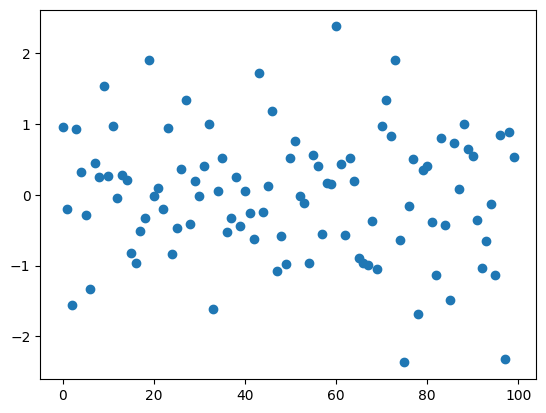

In [216]:
plt.plot(np.arange(0,100), df.spend.values - pred, "o")

In [287]:
n_total = max(np.concatenate([df.cust_id.values, df_new.cust_id.values]))+1

In [291]:
n_old = df.cust_id.nunique()

In [277]:
prior_beta_new = trace.posterior["beta"].mean().values
prior_cust_exp_new = trace.posterior["cust_exp"].mean(axis=0).mean(axis=0).values
prior_alpha_new = trace.posterior["alpha"].mean().values

n_new = max

In [278]:
prior_cust_exp_new = np.append(prior_cust_exp_new, [0]*n_new)

In [279]:
with pm.Model() as new_model:

    obs = pm.MutableData('obs', df_new.spend.values)
    x = pm.MutableData('x', df_new.x.values)
    cust_id = pm.MutableData("cust_id", df_new.cust_id.values)

    sig = pm.HalfNormal("sig", sigma=10)
    beta = pm.Normal("beta", mu=prior_beta_new, sigma=10)
    alpha = pm.Normal("alpha", mu=prior_alpha_new, sigma=10)

    cust_exp = pm.Normal("cust_exp", mu=prior_cust_exp_new, sigma=5)
    y = pm.Normal("y", mu=cust_exp[cust_id] + beta*x, sigma=sig, observed=obs)
        
    trace_new = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig, beta, alpha, cust_exp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
trace.posterior["beta"].mean()

<Axes: xlabel='y / y'>

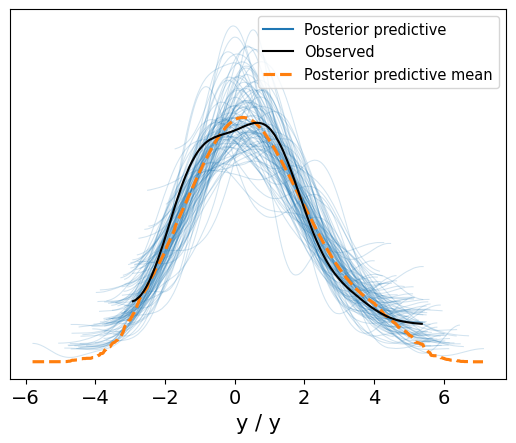

In [126]:
az.plot_ppc(trace, num_pp_samples=100)

<Axes: xlabel='cust_id'>

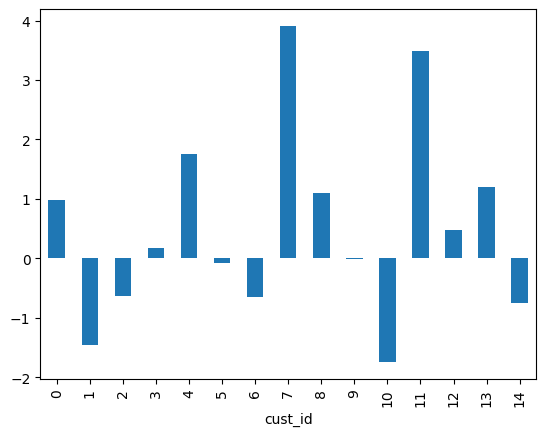

In [127]:
df.groupby("cust_id").spend.mean().plot(kind="bar")

In [ ]:
df[["cust_id", "spend"]]

In [ ]:
plt.plot(df.x, df.spend, 'o')